In [8]:
# ============================================================
# ✅ FULL END-TO-END RUNNABLE SCRIPT (FIXED)
# Z-CROSS (Train on one PROMISE dataset, Test on another)
#
# ✅ FIXES ADDED (for NaN in MLP / correlations):
#   1) safe_spearman(): never returns NaN (handles constant vectors / inf / nan)
#   2) spearman_rank_corr() uses safe_spearman()
#   3) rescale01_rho() returns 0.5 for NaN (neutral) instead of NaN
#   4) Stability + ReliabilityIndex use safe_mean() (no NaN propagation)
#   5) Concordance overlap/rank correlations are safe
#   6) SHAP vectors sanitized to avoid NaN/inf
# ============================================================

import os, re, random, numpy as np, pandas as pd, shap, matplotlib.pyplot as plt, warnings
from dataclasses import dataclass
from typing import Optional, List, Tuple, Dict
from scipy.io import arff
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr

warnings.filterwarnings("ignore")
pd.set_option("display.float_format", lambda x: f"{x:.3f}")

try:
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None
try:
    from lightgbm import LGBMClassifier
except Exception:
    LGBMClassifier = None
try:
    from catboost import CatBoostClassifier
except Exception:
    CatBoostClassifier = None

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


# ============================================================
# ✅ SET YOUR DATASET DIRECTORY HERE
# ============================================================
BASE_PATH = "/content/"


# ============================================================
# ✅ Robust correlation utilities (NO NaNs)
# ============================================================
def _to_1d(a):
    a = np.asarray(a).reshape(-1).astype(float)
    return np.nan_to_num(a, nan=0.0, posinf=0.0, neginf=0.0)

def safe_spearman(a, b, eps=1e-12, default=0.0) -> float:
    """
    Spearman rho that never returns NaN.
    - If vectors are constant / too small / mismatch: returns default (0.0).
    """
    a = _to_1d(a)
    b = _to_1d(b)
    if a.size < 2 or b.size < 2 or a.size != b.size:
        return float(default)
    if np.std(a) < eps or np.std(b) < eps:
        return float(default)
    rho = spearmanr(a, b).correlation
    if rho is None or np.isnan(rho) or np.isinf(rho):
        return float(default)
    return float(rho)

def safe_mean(x, default=0.0) -> float:
    x = np.asarray(list(x), dtype=float)
    x = np.nan_to_num(x, nan=np.nan, posinf=np.nan, neginf=np.nan)
    x = x[~np.isnan(x)]
    if x.size == 0:
        return float(default)
    return float(np.mean(x))


# ============================================================
# Helpers
# ============================================================
def set_seed(s: Optional[int]):
    if s is None: return
    random.seed(s)
    np.random.seed(s)
    os.environ["PYTHONHASHSEED"] = str(s)
    torch.manual_seed(s)

def drop_constant_and_fillna(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    bad = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
    if bad:
        X.drop(columns=bad, inplace=True)
    if X.isna().any().any():
        X = X.fillna(method="ffill").fillna(method="bfill")
    return X

def _to_float32(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if pd.api.types.is_float_dtype(df[c]):
            df[c] = df[c].astype(np.float32)
    return df

def spearman_rank_corr(a: pd.Series, b: pd.Series) -> float:
    """
    Safe Spearman on aligned indices. Never returns NaN.
    """
    a, b = a.align(b, join="inner")
    if len(a) < 2:
        return 0.0
    return safe_spearman(a.values, b.values, default=0.0)

def rescale01_rho(rho: float) -> float:
    """
    Maps rho in [-1,1] to [0,1]. If rho is NaN -> neutral 0.5 (not NaN).
    """
    if rho is None or (isinstance(rho, float) and np.isnan(rho)):
        return 0.5
    return 0.5 * (float(rho) + 1.0)

def _decode_bytes_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == object and len(df[c]) > 0 and isinstance(df[c].iloc[0], (bytes, bytearray)):
            df[c] = df[c].apply(lambda x: x.decode("utf-8", "ignore") if isinstance(x, (bytes, bytearray)) else x)
    return df

def _binarize_target(y: pd.Series) -> pd.Series:
    y = y.copy()
    if pd.api.types.is_numeric_dtype(y):
        uniq = pd.unique(y)
        if len(uniq) > 2:
            return (y.astype(float) > 0).astype(int)
        vals = set(pd.unique(y))
        if vals.issubset({0, 1}):
            return y.astype(int)
        if vals.issubset({1, 2}):
            return (y.astype(int) == 2).astype(int)
        return (y.astype(float) > 0).astype(int)

    y_ = y.astype(str).str.strip().str.lower()
    truthy = {"true", "y", "yes", "defect", "defects", "bug", "bugs", "t", "1"}
    falsy  = {"false", "n", "no", "clean", "f", "0"}
    return y_.apply(lambda v: 1 if (v in truthy) else (0 if v in falsy else (1 if v not in falsy else 0))).astype(int)

def _ensure_df(X, cols: List[str]) -> pd.DataFrame:
    if isinstance(X, pd.DataFrame):
        return X[cols] if list(X.columns) != list(cols) else X
    return pd.DataFrame(np.asarray(X), columns=cols)

def _mean_abs_by_feature(sv, n_features: int) -> np.ndarray:
    if isinstance(sv, list):
        arr = np.asarray(sv[1] if len(sv) >= 2 else sv[0])
    else:
        arr = np.asarray(sv)

    if arr.ndim == 2 and arr.shape[1] == n_features:
        out = np.abs(arr).mean(axis=0)
        return np.nan_to_num(out, nan=0.0, posinf=0.0, neginf=0.0)

    feat_axes = [ax for ax, d in enumerate(arr.shape) if d == n_features]
    if feat_axes:
        arr = np.moveaxis(arr, feat_axes[0], -1)
        out = np.abs(arr).mean(axis=tuple(range(arr.ndim - 1)))
        return np.nan_to_num(out, nan=0.0, posinf=0.0, neginf=0.0)

    out = np.abs(arr.reshape(-1, n_features)).mean(axis=0)
    return np.nan_to_num(out, nan=0.0, posinf=0.0, neginf=0.0)


# ============================================================
# Column canonicalization + feature alignment
# ============================================================
def _canon(c: str) -> str:
    return re.sub(r"\s+", "", str(c).strip()).upper()

PC1_TO_NASA_MAP = {
    "loc": "LOC_EXECUTABLE",
    "lOComment": "LOC_COMMENTS",
    "locCodeAndComment": "LOC_CODE_AND_COMMENT",
    "v(g)": "CYCLOMATIC_COMPLEXITY",
    "iv(G)": "DESIGN_COMPLEXITY",
    "ev(g)": "ESSENTIAL_COMPLEXITY",
    "D": "HALSTEAD_DIFFICULTY",
    "E": "HALSTEAD_EFFORT",
    "I": "HALSTEAD_CONTENT",
    "B": "HALSTEAD_ERROR_EST",
}
NASA_TO_PC1_MAP = {v: k for k, v in PC1_TO_NASA_MAP.items()}

def align_train_test_features_auto(
    Xtr: pd.DataFrame,
    Xte: pd.DataFrame,
    min_common: int = 5
) -> Tuple[pd.DataFrame, pd.DataFrame, List[str], str]:

    Xtr = Xtr.copy()
    Xte = Xte.copy()

    common_exact = sorted(list(set(Xtr.columns).intersection(set(Xte.columns))))
    if len(common_exact) >= min_common:
        return Xtr[common_exact].copy(), Xte[common_exact].copy(), common_exact, "EXACT"

    tr_map = {_canon(c): c for c in Xtr.columns}
    te_map = {_canon(c): c for c in Xte.columns}

    def _apply_mapping(map_dict: Dict[str, str], mode_name: str):
        tr_sel, te_sel, names = [], [], []
        for tr_name, te_name in map_dict.items():
            tr_key = _canon(tr_name)
            te_key = _canon(te_name)
            if tr_key in tr_map and te_key in te_map:
                tr_sel.append(tr_map[tr_key])
                te_sel.append(te_map[te_key])
                names.append(f"{tr_name}__to__{te_name}")
        if len(names) >= 3:
            Xt = Xtr[tr_sel].copy()
            Xe = Xte[te_sel].copy()
            Xt.columns = names
            Xe.columns = names
            return Xt, Xe, names, mode_name
        return None

    out = _apply_mapping(PC1_TO_NASA_MAP, "MAP_PC1_TO_NASA")
    if out is not None:
        return out

    out = _apply_mapping(NASA_TO_PC1_MAP, "MAP_NASA_TO_PC1")
    if out is not None:
        return out

    print("DEBUG: exact common =", len(common_exact))
    print("DEBUG: train cols sample:", list(Xtr.columns)[:20])
    print("DEBUG: test cols sample :", list(Xte.columns)[:20])
    raise ValueError("No common features (no exact match and mapping failed).")


# ============================================================
# ✅ Robust numeric extraction
# ============================================================
def to_numeric_features_only(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    for c in df.columns:
        if df[c].dtype == object:
            df[c] = df[c].apply(lambda x: x.decode("utf-8", "ignore") if isinstance(x, (bytes, bytearray)) else x)
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(axis=1, how="all")
    return df


# ============================================================
# Config
# ============================================================
@dataclass
class PipelineConfig:
    target_col: Optional[str] = None
    rng: int = 42

    zcross_repeats: int = 5
    use_smote: bool = True
    smote_k_max: int = 5

    shap_background_size: int = 1024
    shap_eval_size: int = 6000
    shap_nsamples: int = 200
    shap_mode: str = "auto"
    fast_mode: bool = True
    fast_shap_k: int = 64

    perm_repeats: int = 15
    perm_max_features: Optional[int] = None
    concordance_top_k: int = 25

    rf_n_estimators: int = 400
    rf_max_depth: Optional[int] = 12
    rf_min_samples_leaf: int = 3


# ============================================================
# Dataset loading
# ============================================================
TARGET_CANDIDATES = ["Defective","defective","defects","bug","bugs","class","label","target","c"]

def _resolve_dataset(dataset: str) -> Tuple[str, Optional[str]]:
    ds = dataset.strip()

    if os.path.exists(ds):
        return ds, None

    candidate = os.path.join(BASE_PATH, ds)
    if os.path.exists(candidate):
        return candidate, None

    alias_map = {"PC1":"pc1.arff","PC2":"pc2.arff","PC3":"pc3.arff","PC4":"pc4.arff",
                 "MC1":"mc1.arff","MC2":"mc2.arff","MW1":"mw1.arff","CM1":"CM1.csv"}
    key = ds.upper()
    if key in alias_map:
        p = os.path.join(BASE_PATH, alias_map[key])
        return p, ("Defective" if key == "CM1" else None)

    raise FileNotFoundError(f"Dataset '{dataset}' not found under {BASE_PATH}")

def _read_arff(path: str) -> pd.DataFrame:
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    return _decode_bytes_cols(df)

def _read_csv(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

def _auto_find_target(df: pd.DataFrame, hint: Optional[str]) -> str:
    if hint and hint in df.columns:
        return hint
    lowmap = {c.lower(): c for c in df.columns}
    for k in TARGET_CANDIDATES:
        if k.lower() in lowmap:
            return lowmap[k.lower()]
    return df.columns[-1]

def load_dataset(dataset: str, target_col: Optional[str] = None) -> Tuple[pd.DataFrame, pd.Series]:
    path, suggested = _resolve_dataset(dataset)
    ext = os.path.splitext(path)[1].lower()
    if ext == ".arff":
        df = _read_arff(path)
    elif ext == ".csv":
        df = _read_csv(path)
    else:
        raise ValueError(f"Unsupported: {ext}")

    tgt = target_col or _auto_find_target(df, suggested)
    y = _binarize_target(df[tgt].copy())
    X = to_numeric_features_only(df.drop(columns=[tgt]).copy())
    return X, y


# ============================================================
# Models + build_model
# ============================================================
class BaseModel:
    def __init__(self, cfg: PipelineConfig, random_state: int):
        self.cfg = cfg
        self._cols: List[str] = []

    def fit(self, X: pd.DataFrame, y: pd.Series): raise NotImplementedError
    def predict_proba(self, X: pd.DataFrame) -> np.ndarray: raise NotImplementedError
    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame) -> pd.Series: raise NotImplementedError

class SklearnTreeLike(BaseModel):
    def __init__(self, estimator, cfg: PipelineConfig, random_state: int):
        super().__init__(cfg, random_state)
        self.model = estimator

    def fit(self, X: pd.DataFrame, y: pd.Series):
        X = _to_float32(X)
        self._cols = list(X.columns)
        self.model.fit(X[self._cols], y)
        return self

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        X = _ensure_df(X, self._cols)
        X = _to_float32(X)
        return self.model.predict_proba(X[self._cols])

    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame) -> pd.Series:
        if getattr(self.cfg, "shap_mode", "auto") == "disable":
            return pd.Series(dtype=float)

        cols = self._cols
        rng = np.random.RandomState(0)

        k = min(self.cfg.fast_shap_k, max(1, len(X_bg))) if self.cfg.fast_mode else min(
            256, max(1, min(len(X_bg), self.cfg.shap_background_size))
        )
        bg = X_bg.copy()
        if len(bg) > k:
            bg = bg.iloc[rng.choice(len(bg), size=k, replace=False)]

        X_eval = _ensure_df(X_eval, cols)
        if len(X_eval) > self.cfg.shap_eval_size:
            X_eval = X_eval.iloc[rng.choice(len(X_eval), size=self.cfg.shap_eval_size, replace=False)]

        try:
            expl = shap.TreeExplainer(
                self.model,
                data=bg,
                feature_perturbation="tree_path_dependent",
                model_output="probability"
            )
            sv = expl.shap_values(X_eval, check_additivity=False)
        except Exception:
            def f_np(Z):
                Z = _ensure_df(Z, cols)
                return self.predict_proba(Z)[:, 1]
            expl = shap.KernelExplainer(f_np, bg, link="identity")
            sv = expl.shap_values(X_eval, nsamples=self.cfg.shap_nsamples)

        imp_vec = _mean_abs_by_feature(sv, n_features=len(cols))
        imp_vec = np.nan_to_num(imp_vec, nan=0.0, posinf=0.0, neginf=0.0)
        return pd.Series(imp_vec, index=cols, name="mean|SHAP|")

class RandomForestModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        est = RandomForestClassifier(
            n_estimators=cfg.rf_n_estimators,
            max_depth=cfg.rf_max_depth,
            min_samples_leaf=cfg.rf_min_samples_leaf,
            random_state=random_state,
            n_jobs=-1,
            class_weight="balanced_subsample",
        )
        super().__init__(est, cfg, random_state)

class ExtraTreesModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        est = ExtraTreesClassifier(
            n_estimators=cfg.rf_n_estimators,
            max_depth=cfg.rf_max_depth,
            min_samples_leaf=cfg.rf_min_samples_leaf,
            random_state=random_state,
            n_jobs=-1,
            class_weight="balanced_subsample",
        )
        super().__init__(est, cfg, random_state)

class GradientBoostingModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        est = GradientBoostingClassifier(
            n_estimators=300, learning_rate=0.05, max_depth=3, random_state=random_state
        )
        super().__init__(est, cfg, random_state)

class AdaBoostModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        est = AdaBoostClassifier(
            n_estimators=300, learning_rate=0.05, random_state=random_state
        )
        super().__init__(est, cfg, random_state)

class XGBModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        if XGBClassifier is None:
            raise ImportError("xgboost not installed")
        est = XGBClassifier(
            n_estimators=400, max_depth=6, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9,
            eval_metric="logloss", random_state=random_state, n_jobs=-1
        )
        super().__init__(est, cfg, random_state)

class LGBMModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        if LGBMClassifier is None:
            raise ImportError("lightgbm not installed")
        est = LGBMClassifier(
            n_estimators=500, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9,
            random_state=random_state, n_jobs=-1,
            class_weight="balanced"
        )
        super().__init__(est, cfg, random_state)

class CatBoostModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        if CatBoostClassifier is None:
            raise ImportError("catboost not installed")
        est = CatBoostClassifier(
            iterations=500, depth=6, learning_rate=0.05,
            loss_function="Logloss", verbose=False, random_state=random_state,
            auto_class_weights="Balanced"
        )
        super().__init__(est, cfg, random_state)

class TorchMLP(nn.Module):
    def __init__(self, d_in: int, hidden: int = 128, layers: int = 2, dropout: float = 0.15):
        super().__init__()
        blocks = []
        d = d_in
        for _ in range(layers):
            blocks += [nn.Linear(d, hidden), nn.ReLU(inplace=True), nn.Dropout(dropout)]
            d = hidden
        blocks += [nn.Linear(d, 1)]
        self.net = nn.Sequential(*blocks)

    def forward(self, x):
        return self.net(x).squeeze(1)

class MLPModel(BaseModel):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        super().__init__(cfg, random_state)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        X = _to_float32(X)
        self._cols = list(X.columns)

        Xv = torch.tensor(X[self._cols].values, dtype=torch.float32)
        yv = torch.tensor(y.values.astype(np.float32), dtype=torch.float32)
        ds = TensorDataset(Xv, yv)
        dl = DataLoader(ds, batch_size=512, shuffle=True, drop_last=False)

        self.model = TorchMLP(d_in=Xv.shape[1]).to(self.device)
        opt = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-5)

        for _ in range(15):
            self.model.train()
            for xb, yb in dl:
                xb = xb.to(self.device)
                yb = yb.to(self.device)
                logits = self.model(xb)
                loss = F.binary_cross_entropy_with_logits(logits, yb)
                opt.zero_grad()
                loss.backward()
                opt.step()
        return self

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        X = _ensure_df(X, self._cols)
        X = _to_float32(X)
        xv = torch.tensor(X[self._cols].values, dtype=torch.float32).to(self.device)
        self.model.eval()
        with torch.no_grad():
            p = torch.sigmoid(self.model(xv)).cpu().numpy()
        p = np.clip(p, 1e-6, 1 - 1e-6)
        return np.c_[1 - p, p]

    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame) -> pd.Series:
        """
        FAST explanation for MLP (no SHAP): gradient-based attribution.
        Computes mean(|grad| * |x|) across samples -> feature importance vector.
        Returns a pd.Series aligned with self._cols (never empty unless X_eval empty).
        """
        if X_eval is None or len(X_eval) == 0:
            return pd.Series(dtype=float)

        # ensure correct columns + float32
        X_eval = _ensure_df(X_eval, self._cols)
        X_eval = _to_float32(X_eval)

        # keep it fast
        rng = np.random.RandomState(0)
        max_eval = min(len(X_eval), 2048 if getattr(self.cfg, "fast_mode", True) else 6000)
        if len(X_eval) > max_eval:
            X_eval = X_eval.iloc[rng.choice(len(X_eval), size=max_eval, replace=False)]

        x = torch.tensor(X_eval[self._cols].values, dtype=torch.float32, device=self.device, requires_grad=True)

        self.model.eval()
        # forward -> probs
        logits = self.model(x)
        probs = torch.sigmoid(logits)

        # scalar objective for gradients
        score = probs.mean()
        if x.grad is not None:
            x.grad.zero_()
        score.backward()

        # importance: mean(|grad| * |x|)
        g = x.grad.detach()
        imp = (g.abs() * x.detach().abs()).mean(dim=0).detach().cpu().numpy()

        imp = np.nan_to_num(imp, nan=0.0, posinf=0.0, neginf=0.0)
        return pd.Series(imp, index=self._cols, name="mean|GRAD|")


def build_model(model_name: str, cfg: PipelineConfig, random_state: int) -> BaseModel:
    name = model_name.strip().lower()
    if name in ("rf","random_forest","random-forest"):
        return RandomForestModel(cfg, random_state)
    if name in ("et","extra_trees","extratrees"):
        return ExtraTreesModel(cfg, random_state)
    if name in ("gb","gbrt","gradient_boosting"):
        return GradientBoostingModel(cfg, random_state)
    if name in ("ada","adaboost"):
        return AdaBoostModel(cfg, random_state)
    if name in ("xgb","xgboost"):
        return XGBModel(cfg, random_state)
    if name in ("lgb","lgbm","lightgbm"):
        return LGBMModel(cfg, random_state)
    if name in ("cb","catboost"):
        return CatBoostModel(cfg, random_state)
    if name in ("mlp","nn"):
        return MLPModel(cfg, random_state)
    raise ValueError("Unknown model_name")


# ============================================================
# SHAP for Generalizability (train-side)
# ============================================================
def compute_train_shap_for_gen(model, Xfit: pd.DataFrame, Xtrain: pd.DataFrame,
                               cfg: PipelineConfig, seed: int) -> pd.Series:
    if getattr(cfg, "shap_mode", "auto") == "disable":
        return pd.Series(dtype=float)

    rng = np.random.RandomState(seed)
    Xtrain_eval = Xtrain.copy()

    max_eval = min(len(Xtrain_eval), 1200 if cfg.fast_mode else cfg.shap_eval_size)
    if len(Xtrain_eval) > max_eval:
        Xtrain_eval = Xtrain_eval.iloc[rng.choice(len(Xtrain_eval), size=max_eval, replace=False)]

    s = model.shap_importance(Xfit, Xtrain_eval)
    if s is None or s.empty:
        return pd.Series(dtype=float)
    s = s.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return s


# ============================================================
# Concordance: SHAP vs Permutation on TEST (safe)
# ============================================================
def concordance_shap_vs_permutation(model, X_test: pd.DataFrame, y_test: pd.Series, p_te: np.ndarray,
                                    g_te: pd.Series, cfg: PipelineConfig, seed: int) -> float:
    if g_te is None or g_te.empty:
        return 0.0

    g_te = g_te.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    K = min(cfg.concordance_top_k, len(g_te))
    top_shap = g_te.sort_values(ascending=False).head(K).index.tolist()
    perm_pool = top_shap if cfg.perm_max_features is None else top_shap[:cfg.perm_max_features]
    if len(perm_pool) < 2:
        return 0.0

    base_auc = roc_auc_score(y_test, p_te)
    rng0 = np.random.RandomState(1000 + seed)
    rsum = np.zeros(len(perm_pool), dtype=np.float32)

    for _ in range(cfg.perm_repeats):
        Xp = X_test.copy()
        deltas = []
        for c in perm_pool:
            Xp[c] = rng0.permutation(Xp[c].values)
            auc_p = roc_auc_score(y_test, model.predict_proba(Xp)[:, 1])
            deltas.append(max(base_auc - auc_p, 0.0))
            Xp[c] = X_test[c].values
        ranks = pd.Series(deltas, index=perm_pool).rank(pct=True)
        rsum += ranks.values

    perm_rank = pd.Series(rsum / max(1, cfg.perm_repeats), index=perm_pool)
    g_rank = g_te.rank(pct=True)
    perm_rank = perm_rank.rank(pct=True)

    top_overlap = list(set(g_rank.sort_values(ascending=False).head(K).index) &
                       set(perm_rank.sort_values(ascending=False).head(K).index))
    if len(top_overlap) < 2:
        return 0.0

    return spearman_rank_corr(g_rank.loc[top_overlap], perm_rank.loc[top_overlap])


# ============================================================
# Z-CROSS Reliability
# ============================================================
def run_reliability_zcross(
    X_train: pd.DataFrame, y_train: pd.Series,
    X_test: pd.DataFrame,  y_test: pd.Series,
    cfg: PipelineConfig, model_name: str,
):
    set_seed(cfg.rng)

    X_train = _to_float32(drop_constant_and_fillna(X_train))
    X_test  = _to_float32(drop_constant_and_fillna(X_test))

    X_train, X_test, cols, mode = align_train_test_features_auto(X_train, X_test, min_common=5)
    print(f"[ALIGN:{mode}] common_features={len(cols)}")

    rows = []
    test_expls = []

    for rep in range(1, cfg.zcross_repeats + 1):
        seed = cfg.rng + rep
        set_seed(seed)

        Xfit, yfit = X_train, y_train
        if cfg.use_smote:
            try:
                minority = int((y_train == 1).sum())
                k = min(cfg.smote_k_max, max(1, minority - 1))
                Xfit, yfit = SMOTE(random_state=seed, k_neighbors=k).fit_resample(X_train, y_train)
            except Exception:
                pass

        model = build_model(model_name, cfg, random_state=seed).fit(Xfit, yfit)

        p_tr = model.predict_proba(X_train)[:, 1]
        yhat_tr = (p_tr >= 0.5).astype(int)

        p_te = model.predict_proba(X_test)[:, 1]
        yhat_te = (p_te >= 0.5).astype(int)

        train_auc = roc_auc_score(y_train, p_tr)
        test_auc  = roc_auc_score(y_test,  p_te)

        g_te = model.shap_importance(Xfit, X_test)
        if g_te is None:
            g_te = pd.Series(dtype=float)
        else:
            g_te = g_te.replace([np.inf, -np.inf], np.nan).fillna(0.0)

        test_expls.append(g_te)

        gen = 0.0
        if not g_te.empty:
            g_tr = compute_train_shap_for_gen(model, Xfit, X_train, cfg, seed=seed)
            if not g_tr.empty:
                gen = spearman_rank_corr(g_tr, g_te)

        conc = concordance_shap_vs_permutation(model, X_test, y_test, p_te, g_te, cfg, seed=seed)

        rows.append({
            "rep": rep,
            "Train_AUC": train_auc,
            "Train_F1": f1_score(y_train, yhat_tr, zero_division=0),
            "Train_Precision": precision_score(y_train, yhat_tr, zero_division=0),
            "Train_Recall": recall_score(y_train, yhat_tr, zero_division=0),

            "AUC": test_auc,
            "F1": f1_score(y_test, yhat_te, zero_division=0),
            "Precision": precision_score(y_test, yhat_te, zero_division=0),
            "Recall": recall_score(y_test, yhat_te, zero_division=0),

            "Generalizability": gen,
            "Concordance": conc
        })

    perf = pd.DataFrame(rows)

    # Stability: mean pairwise spearman among TEST explanations across repeats (safe)
    def _mean_pairwise_spearman(series_list: List[pd.Series]) -> float:
        series_list = [s for s in series_list if s is not None and not s.empty]
        if len(series_list) < 2:
            return 0.0
        vals = []
        for i in range(len(series_list)):
            for j in range(i + 1, len(series_list)):
                vals.append(spearman_rank_corr(series_list[i], series_list[j]))
        return safe_mean(vals, default=0.0)

    stability = _mean_pairwise_spearman(test_expls)

    gap = float(perf["Train_AUC"].mean()) - float(perf["AUC"].mean())

    # ReliabilityIndex: safe aggregation (never NaN)
    ri = safe_mean([
        rescale01_rho(perf["Generalizability"].mean()),
        rescale01_rho(perf["Concordance"].mean()),
        rescale01_rho(stability)
    ], default=0.5)

    summary = pd.DataFrame([{
        "Model": model_name,
        "Train_AUC_mean": float(perf["Train_AUC"].mean()),
        "AUC_mean": float(perf["AUC"].mean()),
        "F1_mean": float(perf["F1"].mean()),
        "Precision_mean": float(perf["Precision"].mean()),
        "Recall_mean": float(perf["Recall"].mean()),
        "Generalizability_mean": float(perf["Generalizability"].mean()),
        "Concordance_mean": float(perf["Concordance"].mean()),
        "Stability": float(stability),
        "ReliabilityIndex": float(ri),
        "OverfitGap": float(gap),
        "Repeats": int(cfg.zcross_repeats),
        "n_features_common": int(len(cols)),
    }])

    mean_imp = pd.Series(dtype=float)
    expls = [s for s in test_expls if s is not None and not s.empty]
    if len(expls) > 0:
        mean_imp = pd.concat(expls, axis=1).mean(axis=1).replace([np.inf, -np.inf], np.nan).fillna(0.0)
        mean_imp = mean_imp.sort_values(ascending=False)

    return summary, {"per_repeat": perf, "mean_importance_test": mean_imp}


# ============================================================
# Selected PC pairs (12 directed)
# ============================================================
SELECTED_PAIRS = [
    ("pc1.arff","pc2.arff"), ("pc1.arff","pc3.arff"), ("pc1.arff","pc4.arff"),
    ("pc2.arff","pc1.arff"), ("pc2.arff","pc3.arff"), ("pc2.arff","pc4.arff"),
    ("pc3.arff","pc1.arff"), ("pc3.arff","pc2.arff"), ("pc3.arff","pc4.arff"),
    ("pc4.arff","pc1.arff"), ("pc4.arff","pc2.arff"), ("pc4.arff","pc3.arff"),
]

def run_selected_zcross_pairs(
    model_name: str = "random_forest",
    cfg_overrides: Optional[Dict] = None,
    save_csv_path: Optional[str] = None
):
    cfg = PipelineConfig()
    if cfg_overrides:
        for k, v in cfg_overrides.items():
            if hasattr(cfg, k): setattr(cfg, k, v)
            else: raise KeyError(f"Invalid override: {k}")

    all_rows = []
    artifacts = {}

    for tr, te in SELECTED_PAIRS:
        Xtr, ytr = load_dataset(tr, target_col=cfg.target_col)
        Xte, yte = load_dataset(te, target_col=cfg.target_col)

        summ, arts = run_reliability_zcross(Xtr, ytr, Xte, yte, cfg, model_name=model_name)
        summ.insert(0, "TrainDataset", tr)
        summ.insert(1, "TestDataset", te)

        all_rows.append(summ.iloc[0].to_dict())
        artifacts[(tr, te)] = arts

        print(f"\n=== {tr} → {te} ({model_name}) ===")
        display_round = {
            "Train_AUC_mean": 4,
            "AUC_mean": 4,
            "F1_mean": 4,
            "Precision_mean": 4,
            "Recall_mean": 4,
            "Generalizability_mean": 4,
            "Concordance_mean": 4,
            "Stability": 4,
            "ReliabilityIndex": 3,
            "OverfitGap": 4
        }
        print(summ.round(display_round).to_string(index=False))

    out = pd.DataFrame(all_rows)

    if save_csv_path:
        out.to_csv(save_csv_path, index=False, float_format="%.3f")
        print(f"\nSaved summary CSV: {save_csv_path}")

    return out, artifacts


def plot_topk(importance: pd.Series, top_k=10, title=None):
    if importance is None or importance.empty:
        return
    imp = importance.sort_values(ascending=False).head(min(top_k, len(importance)))
    y = np.arange(len(imp))
    plt.figure(figsize=(9, max(4, 0.5 * len(imp))))
    plt.barh(y, imp.values)
    plt.yticks(y, imp.index)
    plt.gca().invert_yaxis()
    plt.xlabel("importance")
    plt.title(title or f"Top {len(imp)} — importance")
    plt.tight_layout()
    plt.show()

# ============================================================
# Example run:
# summary_df, zcross_artifacts = run_selected_zcross_pairs(
#     model_name="mlp",
#     cfg_overrides={"zcross_repeats": 5, "use_smote": True},
#     save_csv_path=os.path.join(BASE_PATH, "zcross_mlp.csv"),
# )
# ============================================================


In [9]:
summary_df, zcross_artifacts = run_selected_zcross_pairs(
    model_name="mlp",
    cfg_overrides={"zcross_repeats": 5, "use_smote": True},
    save_csv_path=os.path.join(BASE_PATH, "zcross_mlp.csv")
)

[ALIGN:MAP_PC1_TO_NASA] common_features=10

=== pc1.arff → pc2.arff (mlp) ===
TrainDataset TestDataset Model  Train_AUC_mean  AUC_mean  F1_mean  Precision_mean  Recall_mean  Generalizability_mean  Concordance_mean  Stability  ReliabilityIndex  OverfitGap  Repeats  n_features_common
    pc1.arff    pc2.arff   mlp           0.610     0.872    0.018           0.009        0.948                  0.859             0.236      0.888             0.831      -0.262        5                 10
[ALIGN:MAP_PC1_TO_NASA] common_features=10

=== pc1.arff → pc3.arff (mlp) ===
TrainDataset TestDataset Model  Train_AUC_mean  AUC_mean  F1_mean  Precision_mean  Recall_mean  Generalizability_mean  Concordance_mean  Stability  ReliabilityIndex  OverfitGap  Repeats  n_features_common
    pc1.arff    pc3.arff   mlp           0.610     0.673    0.199           0.111        0.976                  0.998             0.124      0.907             0.838      -0.062        5                 10
[ALIGN:MAP_PC1_TO_NASA] 

In [10]:
def plot_all_zcross_pairs(
    zcross_artifacts: dict,
    pairs: list,
    top_k: int = 15,
    model_name: str = "",
    only_nonempty: bool = True
):
    """
    Plots Top-K mean SHAP importance for every (train,test) pair in pairs.
    Skips pairs where SHAP importance is missing/empty (common for non-tree models).
    """
    for (tr, te) in pairs:
        key = (tr, te)
        if key not in zcross_artifacts:
            print(f"[SKIP] No artifacts found for {tr} → {te}")
            continue

        imp = zcross_artifacts[key].get("mean_importance_test", None)

        if imp is None or (hasattr(imp, "empty") and imp.empty):
            if only_nonempty:
                print(f"[SKIP] Empty SHAP importance for {tr} → {te}")
                continue
            else:
                print(f"[WARN] Empty SHAP importance for {tr} → {te}")
                # still show nothing
                continue

        title = f"{tr} → {te}"
        if model_name:
            title += f" ({model_name})"
        title += " — mean SHAP on TEST"

        plot_topk(imp, top_k=top_k, title=title)

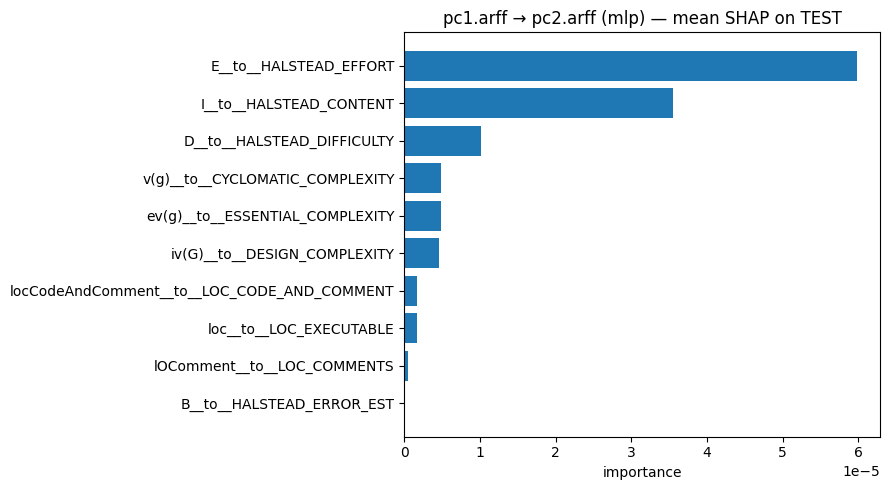

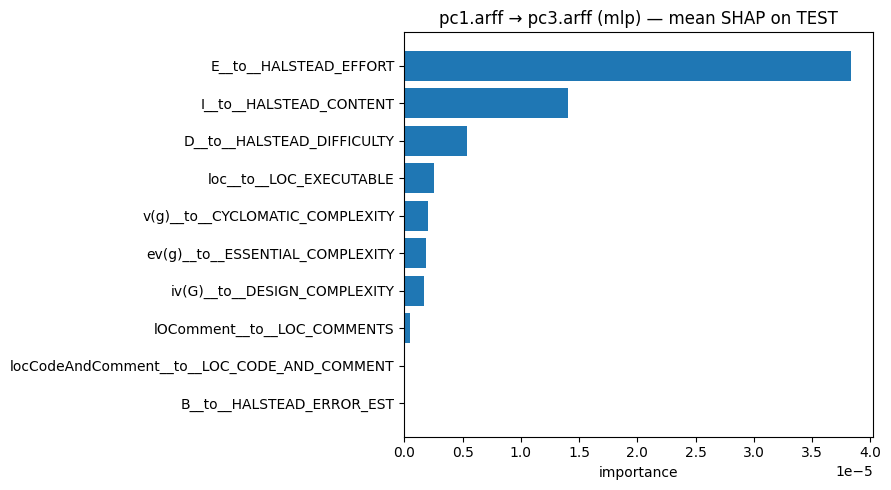

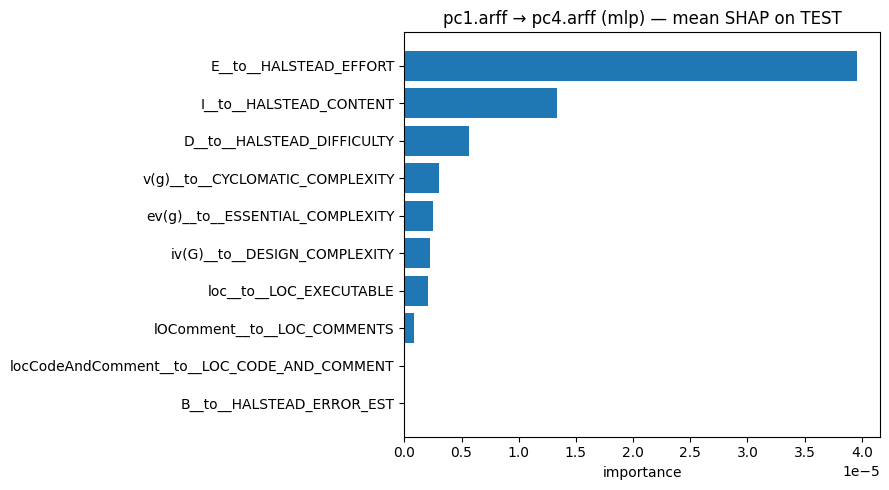

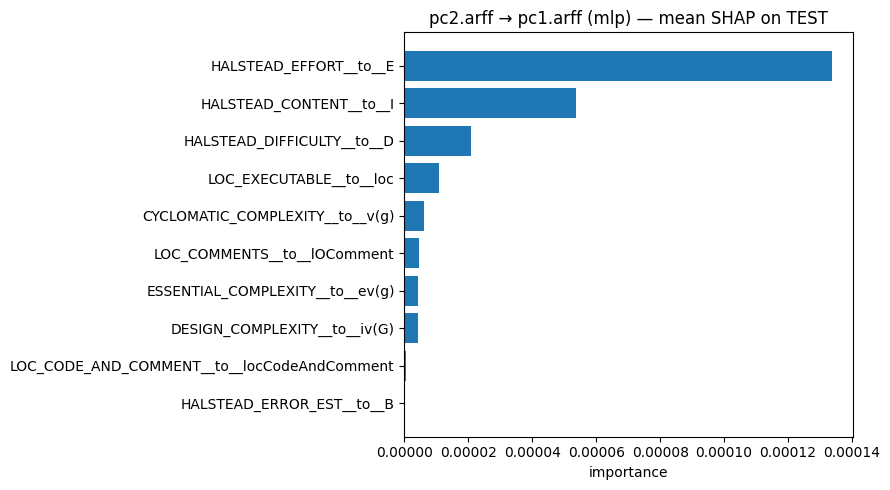

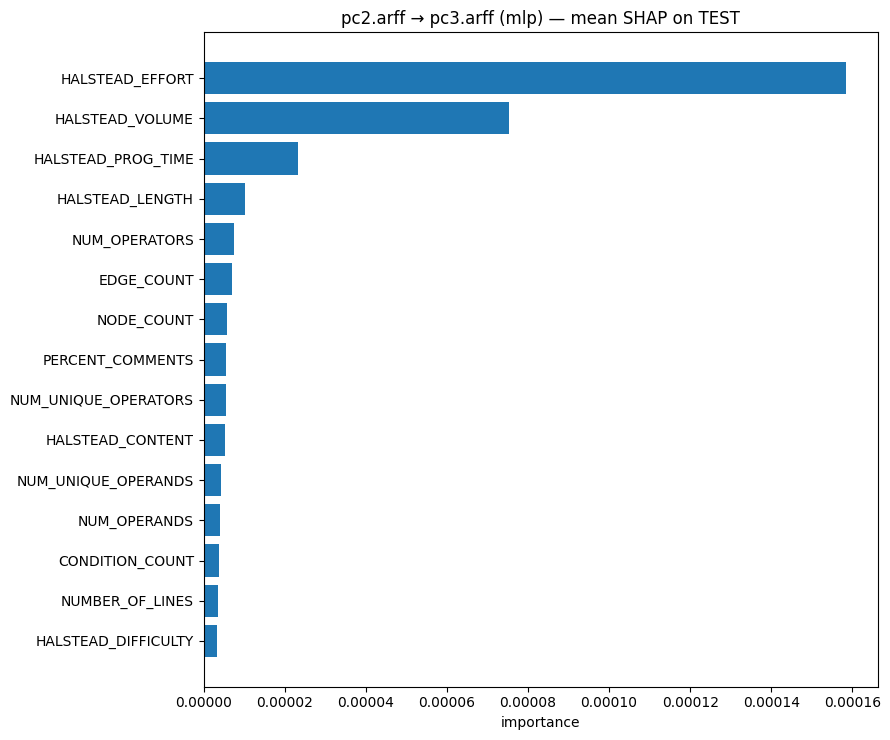

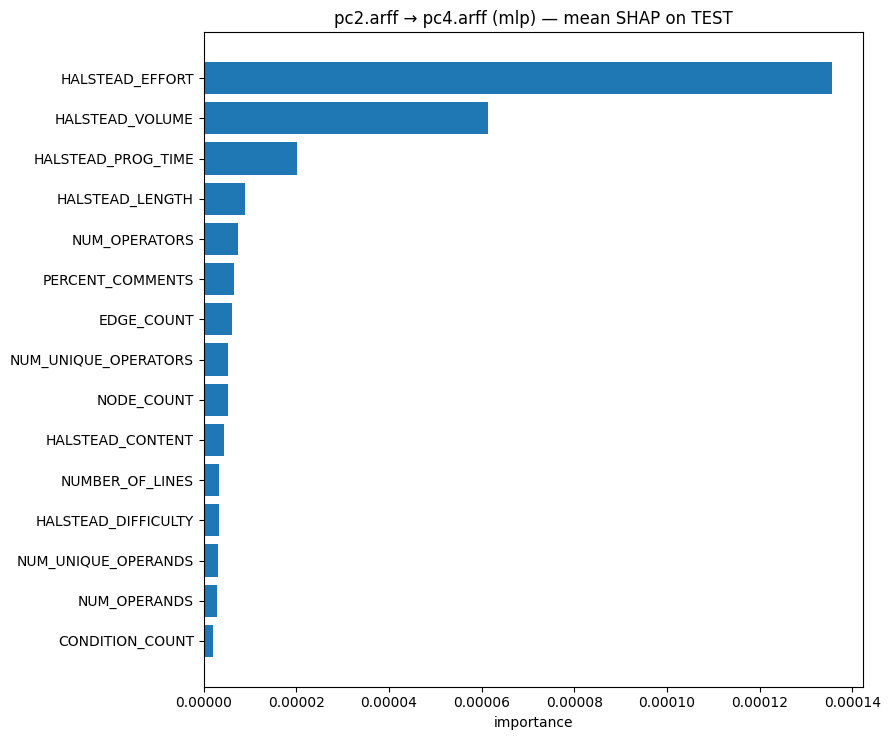

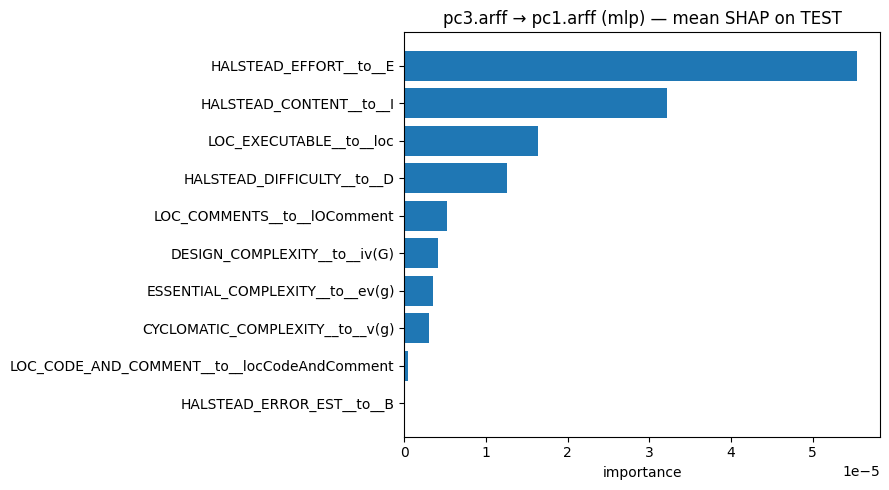

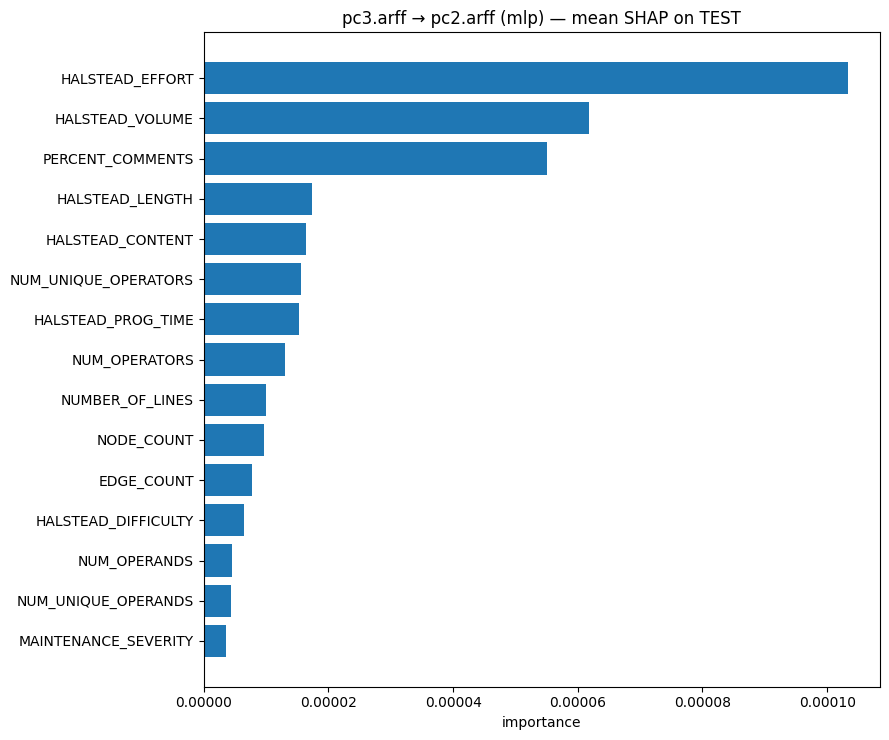

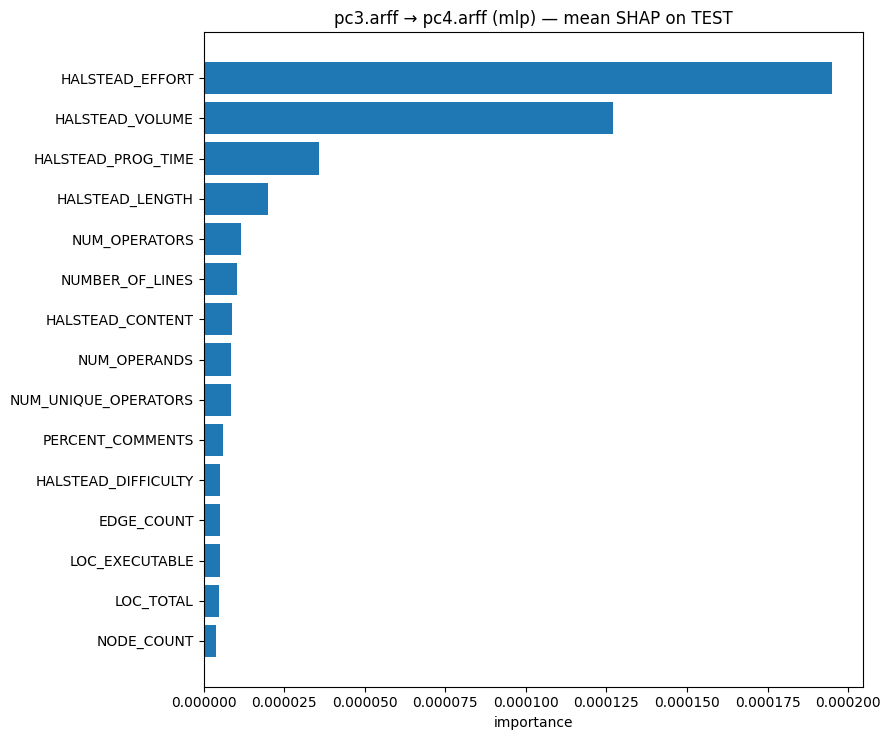

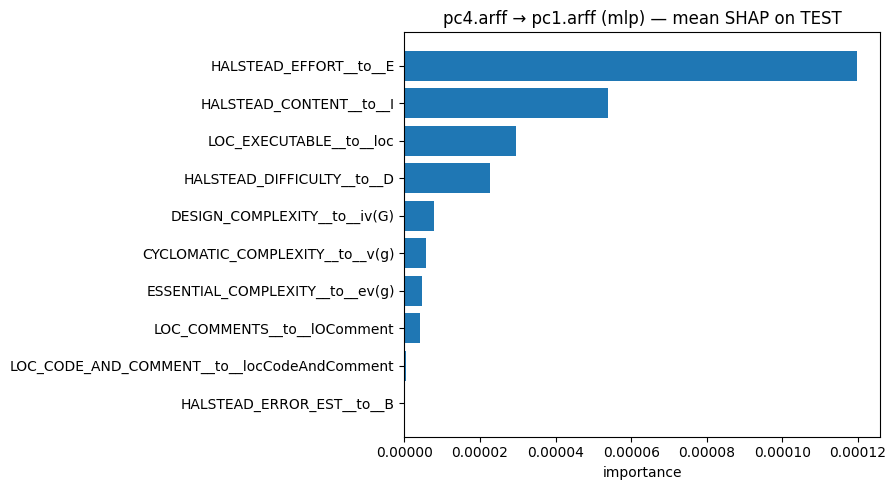

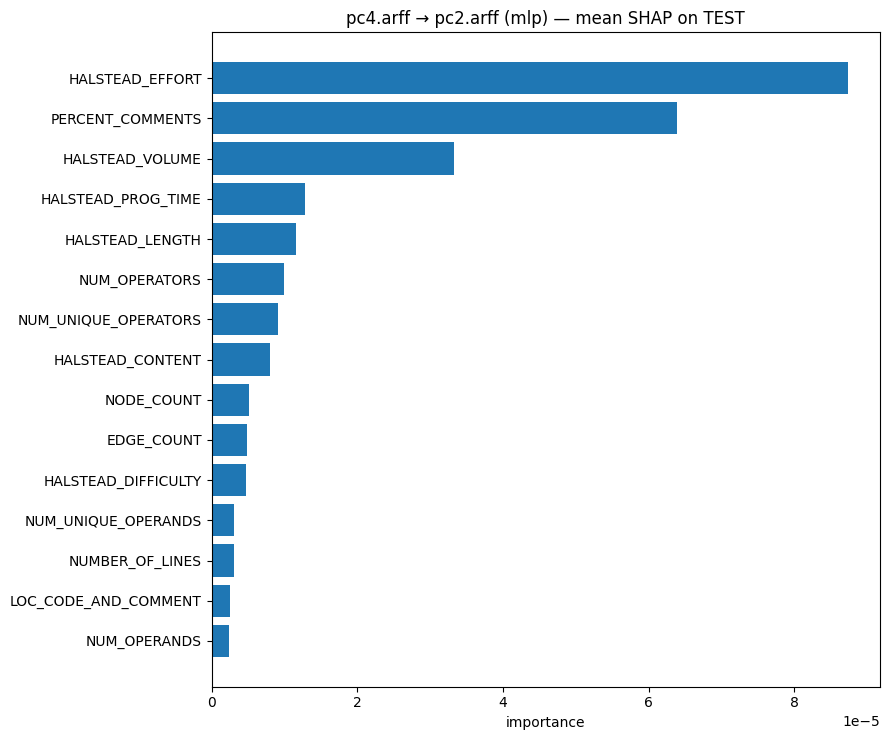

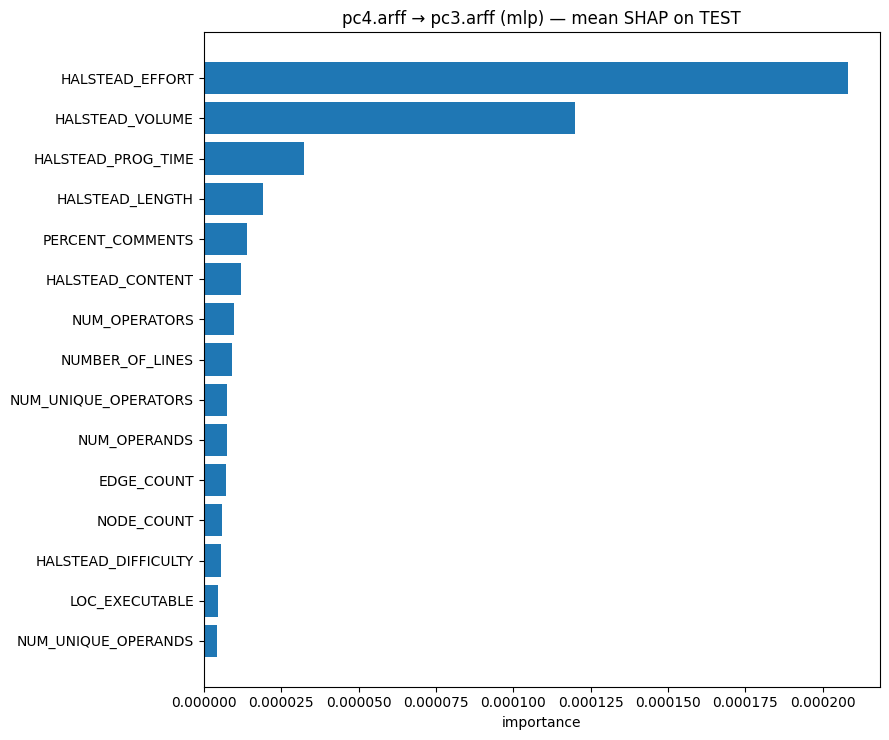

In [11]:
plot_all_zcross_pairs(
    zcross_artifacts=zcross_artifacts,
    pairs=SELECTED_PAIRS,
    top_k=15,
    model_name="mlp"   # optional
)